In [1]:
'''
Zé Fonseca

8/02/16

Test what happens when we fit y=mx+b and de have errors in y and x and when we let x be fitted as well
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
import emcee
%matplotlib inline
import time
import matplotlib.gridspec as gridspec



In [2]:
#functions
#cosmological functions
#general functions

def func(x,m=2,b=1):
    return m*x+b

#class for fake data. Only reason to use class is because this is a copy of another iPython Notebook

class fkd:
    def __init__(self,name,N=5,m=2,b=1,sig_y=0.005,sig_x=0.01):
        #parameters used
        self.N=N
        x=np.random.rand(N)
        x.sort()
        self.x=x
        self.y_t=m*self.x+b
        self.y=self.y_t+np.random.randn(N)*sig_y
        self.x2=x+np.random.randn(N)*sig_x
        self.sig_y=sig_y
        self.sig_x=sig_x
        self.dataset=name


In [3]:
#initiate data and simulate it
N=10
fd=fkd('str_x10_smlerr',N)

# save data and plot it

def save_sim_data(data):
    np.savetxt('data_'+data.dataset+'_zf.txt',np.c_[data.x,data.x2,data.y],fmt='%2.3f',header="x  x2  y")

save_sim_data(fd)

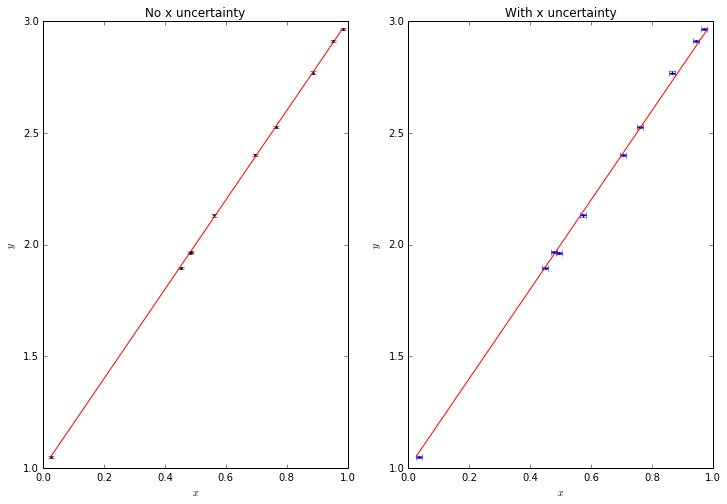

In [4]:
f, axarr = plt.subplots(1,2,figsize=(12,8))
    
axarr[0].errorbar(fd.x,fd.y,yerr=[0.005*np.ones(fd.N),0.005*np.ones(fd.N)],fmt='ko',ms=2)
axarr[0].plot(fd.x,fd.y_t,'r')
axarr[0].set_xlabel(r'$x$')
axarr[0].set_ylabel(r'$y$')
axarr[0].set_title('No x uncertainty')
    
axarr[1].errorbar(fd.x2,fd.y,xerr=[0.01*np.ones(fd.N),0.01*np.ones(fd.N)],yerr=[0.005*np.ones(fd.N),0.005*np.ones(fd.N)],fmt='bo',ms=2)
axarr[1].plot(fd.x,fd.y_t,'r')
axarr[1].set_xlabel(r'$x$')
axarr[1].set_ylabel(r'$y$')
axarr[1].set_title('With x uncertainty')

plt.savefig(fd.dataset+'_zf.pdf')
plt.show()

In [5]:
#MCMC priors

def l_prior(p):
    """Apply a flat prior to cosmological parameters"""
    bounds = [[0, 4], [-5, 5]]
    for i in range(len(bounds)):
        if p[i]< bounds[i][0] or p[i] > bounds[i][1]:
            return False
    return True

def x_prior(p):
    """Apply a flat prior to cosmological parameters"""
    bounds = [-1,2]
    for i in range(len(bounds)):
        if p[i]< bounds[0] or p[i] > bounds[1]:
            return False
    return True

def p_prior(p):
    """Apply a flat prior to cosmological parameters"""
    bounds = [[0,1],[0.01,3]]
    for i in range(len(bounds)):
        if p[i]< bounds[i][0] or p[i] > bounds[i][1]:
            return False
    return True
    
def chi2_p(o,t,sigma2):
    return (o-t)**2/sigma2


In [6]:
def log_like_fixsig(p,data):
    """
    Edited from Michelle Lochner
    ln(posterior probability) function. Std likelihood and prior. Uses scattered x
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    data : class with the data
    Returns
    -------
    log(posterior) : float
    
    """
    if not l_prior(p):
        return -np.inf
    
    m,b = p[:2]    
    y_t = func(data.x2,m,b)
    chi2 = np.sum(chi2_p(data.y,y_t,data.sig_y**2))   
    return -0.5*chi2

def log_like_varsig(p,data):
    """
    Edited from Michelle Lochner
    Error varies at every step
    ln(posterior probability) function. Adds errors in quadrature for unscatered x. Uses scattered x
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    data : class with the data
    Returns
    -------
    log(posterior) : float
    
    """
    if not l_prior(p):
        return -np.inf
    
    m,b = p[:2]    
    y_t = func(data.x2,m,b)
    sigma2=data.sig_y**2+(m*data.sig_x)**2
    return -sum(chi2_p(data.y,y_t,sigma2)+np.log(sigma2))*0.5

def log_like_arabnight(p,data):
    m,b = p[:2]
    X=p[2:]
    
    if not l_prior(p[:3]) or not  x_prior(X):
        return -np.inf  
    
    y_t = func(X,m,b)
    
    chi2_y = np.sum(chi2_p(data.y,y_t,data.sig_y**2)) 
    chi2_x = np.sum(chi2_p(data.x2,X,data.sig_x**2)) 
    
    return -(chi2_y+chi2_x)*0.5

def log_like_arabnight_priorgau(p,data):
    m,b = p[:2]
    x_c,sigxp=p[2:4]
    X=p[4:]
    
    if not l_prior(p[:2]) or not  p_prior(p[2:4]):
        return -np.inf
    
    y_t = func(X,m,b)
    
    chi2_y = np.sum(chi2_p(data.y,y_t,data.sig_y**2)) 
    chi2_x = np.sum(chi2_p(data.x2,X,data.sig_x**2))
    chi2_xp = np.sum(chi2_p(data.x2,x_c,sigxp**2))
    
    return -(chi2_y+chi2_x+chi2_xp+len(X)*np.log(sigxp**2))*0.5

In [7]:
def run_chain(lnprob,data,start_point=[1.1,2.05], proposal_spread=[0.005, 0.005],
             nwalkers=500, ndim=2):
    """Function to run emcee on a dataset (suppied in args)"""
    t1 = time.time()
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))*np.array(proposal_spread) + np.array(start_point)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data])
    pos, prob, state = sampler.run_mcmc(p0,100)
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos,10000)
    
    print('Dataset', data.dataset)

    print('Time taken', time.time() - t1)
    print('Average acceptance ratio', sampler.acceptance_fraction.mean())


    return sampler.flatchain

In [14]:
chain_fixsig=run_chain(log_like_fixsig,fd)
chain_varsig=run_chain(log_like_varsig,fd)
chain_ab_unip=run_chain(log_like_arabnight,fd,start_point=[1.1,2.05]+[0.5]*N,\
          proposal_spread=[0.01]*2+[0.01]*N,ndim=2+N)
chain_ab_gaup=run_chain(log_like_arabnight_priorgau,fd,start_point=[1.1,2.05]+[0.75,0.5]+[0.5]*N,\
          proposal_spread=[0.01]*2+[0.05,0.05]+[0.01]*N,ndim=4+N)

Dataset str_x10_smlerr
Time taken 89.3902940750122
Average acceptance ratio 0.7148954
Dataset str_x10_smlerr
Time taken 87.38658714294434
Average acceptance ratio 0.7155202
Dataset str_x10_smlerr
Time taken 141.04050493240356
Average acceptance ratio 0.3846864
Dataset str_x10_smlerr
Time taken 183.6391339302063
Average acceptance ratio 0.3527624


In [15]:
def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

burn_tail=100
thining=1
nb=100

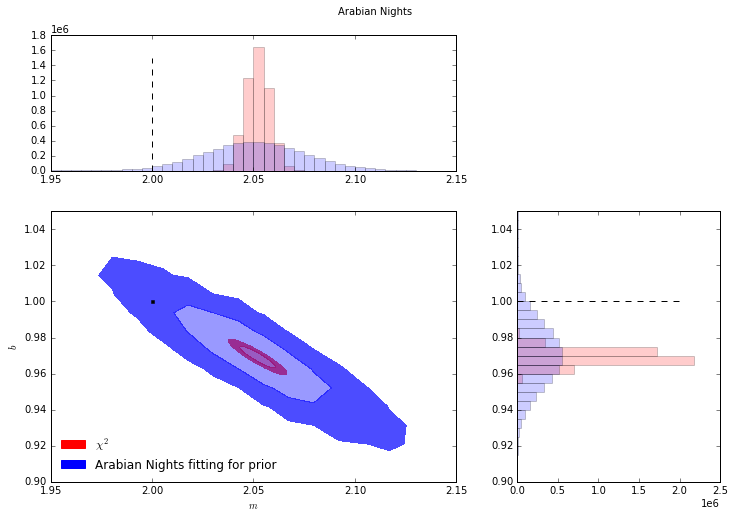

In [31]:
f=plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[2,1],
                       height_ratios=[1,2]
                       )

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

#f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

bins_m=[round(x*0.005+1.8,3) for x in range(0,200)]
bins_b=[round(x*0.005+0.9,3) for x in range(0,100)]

m1=chain_fixsig[:,0]
b1=chain_fixsig[:,1]
#m2=chain_varsig[:,0]
#b2=chain_varsig[:,1]
#m3=chain_ab_unip[:,0]
#b3=chain_ab_unip[:,1]
m4=chain_ab_gaup[:,0]
b4=chain_ab_gaup[:,1]

Hist_mcmc1, medges1,bedges1 = np.histogram2d(m1,b1,bins=(nb, nb))
m_c1=np.array([(medges1[i]+medges1[i+1])/2 for i in range(len(medges1)-1)])
b_c1=np.array([(bedges1[i]+bedges1[i+1])/2 for i in range(len(bedges1)-1)])
Neff1=len(m1)
Nmax1,N681,N951=confidence_levels(Hist_mcmc1,Neff1)

#Hist_mcmc2, medges2,bedges2 = np.histogram2d(m2,b2,bins=(nb, nb))
#m_c2=np.array([(medges2[i]+medges2[i+1])/2 for i in range(len(medges2)-1)])
#b_c2=np.array([(bedges2[i]+bedges2[i+1])/2 for i in range(len(bedges2)-1)])
#Neff2=len(m2)
#Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)

#Hist_mcmc3, medges3,bedges3 = np.histogram2d(m3,b3,bins=(nb, nb))
#m_c3=np.array([(medges3[i]+medges3[i+1])/2 for i in range(len(medges3)-1)])
#b_c3=np.array([(bedges3[i]+bedges3[i+1])/2 for i in range(len(bedges3)-1)])
#Neff3=len(m3)
#Nmax3,N683,N953=confidence_levels(Hist_mcmc3,Neff3)

Hist_mcmc4, medges4,bedges4 = np.histogram2d(m4,b4,bins=(nb, nb))
m_c4=np.array([(medges4[i]+medges4[i+1])/2 for i in range(len(medges4)-1)])
b_c4=np.array([(bedges4[i]+bedges4[i+1])/2 for i in range(len(bedges4)-1)])
Neff4=len(m4)
Nmax4,N684,N954=confidence_levels(Hist_mcmc4,Neff4)

f.text(0.5, 0.95, 'Arabian Nights',horizontalalignment='center',verticalalignment='top')
    
m_min=1.95
m_max=2.15
    
b_min=0.9
b_max=1.05


ax1.hist(m1,color='r',bins=bins_m,alpha=0.2)
#ax1.hist(m2,color='b',bins=bins_m,alpha=0.2)
#ax1.hist(m3,color='g',bins=bins_m,alpha=0.2)
ax1.hist(m4,color='b',bins=bins_m,alpha=0.2)
ax1.plot([2,2],[0,1.5e6],'--k')
ax1.set_xlim([m_min,m_max])
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

import matplotlib as mpl
colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)]
cmap1 = mpl.colors.ListedColormap(colors1)
colors2 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
cmap2 = mpl.colors.ListedColormap(colors2)
colors3 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
cmap3 = mpl.colors.ListedColormap(colors3)
colors4 = [(.0, .0, 0.0, 0.7),(0., 0., 0.0, 0.4)] 
cmap4 = mpl.colors.ListedColormap(colors4)
    
ax3.contourf(m_c1,b_c1, Hist_mcmc1.T,levels=[N951,N681,Nmax1],cmap=cmap1)
#ax3.contour(m_c2,b_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],colors='g')
#ax3.contourf(m_c3,b_c3, Hist_mcmc3.T,levels=[N953,N683,Nmax3],cmap=cmap3)
ax3.contourf(m_c4,b_c4, Hist_mcmc4.T,levels=[N954,N684,Nmax4],cmap=cmap3)
ax3.plot(2.0,1.0,'sk',ms=3)
ax3.set_xlim([m_min,m_max])
ax3.set_ylim([b_min,b_max])
ax3.set_ylabel(r'$b$')
ax3.set_xlabel(r'$m$')
    
ax4.hist(b1,bins=bins_b,color='r',alpha=0.2,orientation=u'horizontal')
#ax4.hist(b2,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
#ax4.hist(b3,bins=bins_b,color='g',alpha=0.2,orientation=u'horizontal')
ax4.hist(b4,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
ax4.plot([0,2e6],[1,1],'--k')#,orientation=u'horizontal')
ax4.set_ylim([b_min,b_max])
ax4.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_patch = mpatches.Patch(color='red', label=r'$\chi^2$')
blue_patch = mpatches.Patch(color='blue',label='Arabian Nights fitting for prior')# label=r'$\chi^2$ with errors in quadrature')
#green_patch = mpatches.Patch(color='green', label='Arabian Nights')
#black_line = mlines.Line2D([], [],color='black', label='Arabian Nights fitting for prior')
ax3.legend(handles=[red_patch,blue_patch],fontsize=12, loc = 'lower left',frameon=False)
plt.savefig('arabnight_str_'+str(N)+'_smlerr_zf.png')
    
plt.show()

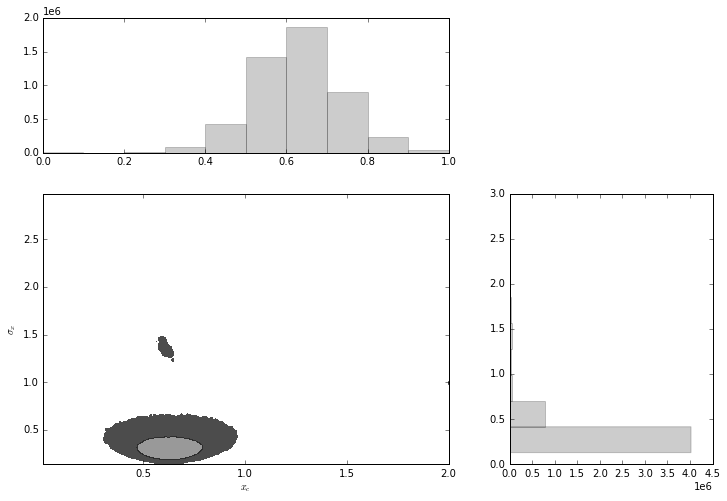

In [17]:
f=plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[2,1],
                       height_ratios=[1,2]
                       )

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])


bins_m=[round(x*0.05+1,3) for x in range(0,100)]
bins_b=[round(x*0.05+0,3) for x in range(0,100)]

m4=chain_ab_gaup[:,2]
b4=chain_ab_gaup[:,3]

Hist_mcmc4, medges4,bedges4 = np.histogram2d(m4,b4,bins=(nb, nb))
m_c4=np.array([(medges4[i]+medges4[i+1])/2 for i in range(len(medges4)-1)])
b_c4=np.array([(bedges4[i]+bedges4[i+1])/2 for i in range(len(bedges4)-1)])
Neff4=len(m4)
Nmax4,N684,N954=confidence_levels(Hist_mcmc4,Neff4)

ax1.hist(m4,color='k',alpha=0.2)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


import matplotlib as mpl
colors4 = [(0.0, 0.0, 0.0, 0.7),(0.0, 0.0, 0.0, 0.4)] 
cmap4 = mpl.colors.ListedColormap(colors4)

ax3.contourf(m_c4,b_c4, Hist_mcmc4.T,levels=[N954,N684,Nmax4],cmap=cmap4)
ax3.plot(2.0,1.0,'sk',ms=3)
ax3.set_ylabel(r'$\sigma_x$')
ax3.set_xlabel(r'$x_c$')

ax4.hist(b4,color='k',alpha=0.2,orientation=u'horizontal')

ax4.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    
plt.show()

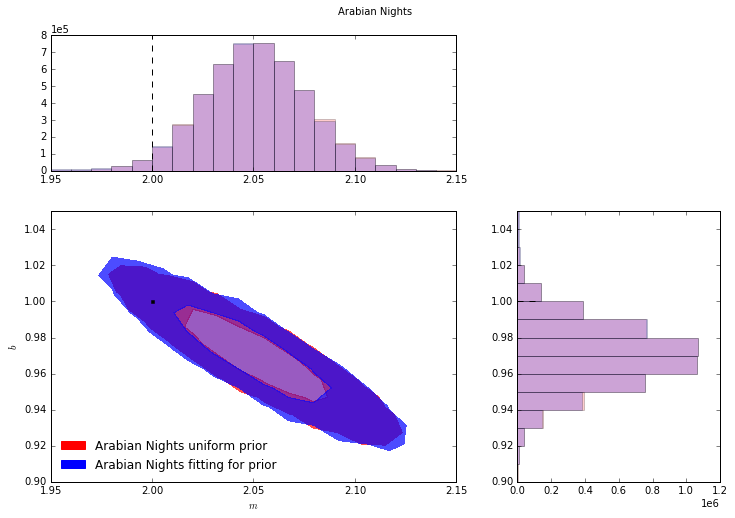

In [29]:
f=plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[2,1],
                       height_ratios=[1,2]
                       )

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

#f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

bins_m=[round(x*0.01+1,3) for x in range(0,200)]
bins_b=[round(x*0.01+0.4,3) for x in range(0,100)]

m3=chain_ab_unip[:,0]
b3=chain_ab_unip[:,1]
m4=chain_ab_gaup[:,0]
b4=chain_ab_gaup[:,1]

Hist_mcmc3, medges3,bedges3 = np.histogram2d(m3,b3,bins=(nb, nb))
m_c3=np.array([(medges3[i]+medges3[i+1])/2 for i in range(len(medges3)-1)])
b_c3=np.array([(bedges3[i]+bedges3[i+1])/2 for i in range(len(bedges3)-1)])
Neff3=len(m3)
Nmax3,N683,N953=confidence_levels(Hist_mcmc3,Neff3)

Hist_mcmc4, medges4,bedges4 = np.histogram2d(m4,b4,bins=(nb, nb))
m_c4=np.array([(medges4[i]+medges4[i+1])/2 for i in range(len(medges4)-1)])
b_c4=np.array([(bedges4[i]+bedges4[i+1])/2 for i in range(len(bedges4)-1)])
Neff4=len(m4)
Nmax4,N684,N954=confidence_levels(Hist_mcmc4,Neff4)

f.text(0.5, 0.95, 'Arabian Nights',horizontalalignment='center',verticalalignment='top')
    
m_min=1.95
m_max=2.15
    
b_min=0.9
b_max=1.05


ax1.hist(m3,color='r',bins=bins_m,alpha=0.2)
ax1.hist(m4,color='b',bins=bins_m,alpha=0.2)
ax1.plot([2,2],[0,8e5],'--k')
ax1.set_xlim([m_min,m_max])
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

import matplotlib as mpl
colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)]
cmap1 = mpl.colors.ListedColormap(colors1)

colors3 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
cmap3 = mpl.colors.ListedColormap(colors3)

    

ax3.contourf(m_c3,b_c3, Hist_mcmc3.T,levels=[N953,N683,Nmax3],cmap=cmap1)
ax3.contourf(m_c4,b_c4, Hist_mcmc4.T,levels=[N954,N684,Nmax4],cmap=cmap3)
ax3.plot(2.0,1.0,'sk',ms=3)
ax3.set_xlim([m_min,m_max])
ax3.set_ylim([b_min,b_max])
ax3.set_ylabel(r'$b$')
ax3.set_xlabel(r'$m$')
    
ax4.hist(b3,bins=bins_b,color='r',alpha=0.2,orientation=u'horizontal')
ax4.hist(b4,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
ax4.plot([0,1.2e5],[1,1],'--k')#,orientation=u'horizontal')
ax4.set_ylim([b_min,b_max])
ax4.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_patch = mpatches.Patch(color='red', label='Arabian Nights uniform prior')
blue_patch = mpatches.Patch(color='blue',label='Arabian Nights fitting for prior')# label=r'$\chi^2$ with errors in quadrature')
#green_patch = mpatches.Patch(color='green', label='Arabian Nights')
#black_line = mlines.Line2D([], [],color='black', label='Arabian Nights fitting for prior')
ax3.legend(handles=[red_patch,blue_patch],fontsize=12, loc = 'lower left',frameon=False)
plt.savefig('arabnight_str_compprior_'+str(N)+'_smlerr_zf.png')
    
plt.show()

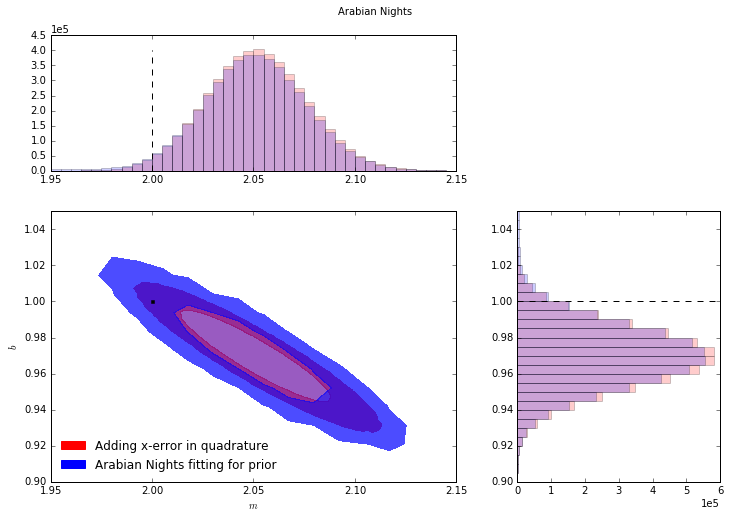

In [26]:
f=plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[2,1],
                       height_ratios=[1,2]
                       )

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

#f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})

bins_m=[round(x*0.005+1.8,3) for x in range(0,200)]
bins_b=[round(x*0.005+0.9,3) for x in range(0,100)]

m1=chain_varsig[:,0]
b1=chain_varsig[:,1]

m4=chain_ab_gaup[:,0]
b4=chain_ab_gaup[:,1]

Hist_mcmc1, medges1,bedges1 = np.histogram2d(m1,b1,bins=(nb, nb))
m_c1=np.array([(medges1[i]+medges1[i+1])/2 for i in range(len(medges1)-1)])
b_c1=np.array([(bedges1[i]+bedges1[i+1])/2 for i in range(len(bedges1)-1)])
Neff1=len(m1)
Nmax1,N681,N951=confidence_levels(Hist_mcmc1,Neff1)

#Hist_mcmc2, medges2,bedges2 = np.histogram2d(m2,b2,bins=(nb, nb))
#m_c2=np.array([(medges2[i]+medges2[i+1])/2 for i in range(len(medges2)-1)])
#b_c2=np.array([(bedges2[i]+bedges2[i+1])/2 for i in range(len(bedges2)-1)])
#Neff2=len(m2)
#Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)

#Hist_mcmc3, medges3,bedges3 = np.histogram2d(m3,b3,bins=(nb, nb))
#m_c3=np.array([(medges3[i]+medges3[i+1])/2 for i in range(len(medges3)-1)])
#b_c3=np.array([(bedges3[i]+bedges3[i+1])/2 for i in range(len(bedges3)-1)])
#Neff3=len(m3)
#Nmax3,N683,N953=confidence_levels(Hist_mcmc3,Neff3)

Hist_mcmc4, medges4,bedges4 = np.histogram2d(m4,b4,bins=(nb, nb))
m_c4=np.array([(medges4[i]+medges4[i+1])/2 for i in range(len(medges4)-1)])
b_c4=np.array([(bedges4[i]+bedges4[i+1])/2 for i in range(len(bedges4)-1)])
Neff4=len(m4)
Nmax4,N684,N954=confidence_levels(Hist_mcmc4,Neff4)

f.text(0.5, 0.95, 'Arabian Nights',horizontalalignment='center',verticalalignment='top')
    
m_min=1.95
m_max=2.15
    
b_min=0.9
b_max=1.05


ax1.hist(m1,color='r',bins=bins_m,alpha=0.2)
#ax1.hist(m2,color='b',bins=bins_m,alpha=0.2)
#ax1.hist(m3,color='g',bins=bins_m,alpha=0.2)
ax1.hist(m4,color='b',bins=bins_m,alpha=0.2)
ax1.plot([2,2],[0,4e5],'--k')
ax1.set_xlim([m_min,m_max])
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

import matplotlib as mpl
colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)]
cmap1 = mpl.colors.ListedColormap(colors1)
colors2 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
cmap2 = mpl.colors.ListedColormap(colors2)
colors3 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
cmap3 = mpl.colors.ListedColormap(colors3)
colors4 = [(.0, .0, 0.0, 0.7),(0., 0., 0.0, 0.4)] 
cmap4 = mpl.colors.ListedColormap(colors4)
    
ax3.contourf(m_c1,b_c1, Hist_mcmc1.T,levels=[N951,N681,Nmax1],cmap=cmap1)
#ax3.contour(m_c2,b_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],colors='g')
#ax3.contourf(m_c3,b_c3, Hist_mcmc3.T,levels=[N953,N683,Nmax3],cmap=cmap3)
ax3.contourf(m_c4,b_c4, Hist_mcmc4.T,levels=[N954,N684,Nmax4],cmap=cmap3)
ax3.plot(2.0,1.0,'sk',ms=3)
ax3.set_xlim([m_min,m_max])
ax3.set_ylim([b_min,b_max])
ax3.set_ylabel(r'$b$')
ax3.set_xlabel(r'$m$')
    
ax4.hist(b1,bins=bins_b,color='r',alpha=0.2,orientation=u'horizontal')
#ax4.hist(b2,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
#ax4.hist(b3,bins=bins_b,color='g',alpha=0.2,orientation=u'horizontal')
ax4.hist(b4,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
ax4.plot([0,6e5],[1,1],'--k')#,orientation=u'horizontal')
ax4.set_ylim([b_min,b_max])
ax4.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_patch = mpatches.Patch(color='red', label='Adding x-error in quadrature')
blue_patch = mpatches.Patch(color='blue',label='Arabian Nights fitting for prior')# label=r'$\chi^2$ with errors in quadrature')
#green_patch = mpatches.Patch(color='green', label='Arabian Nights')
#black_line = mlines.Line2D([], [],color='black', label='Arabian Nights fitting for prior')
ax3.legend(handles=[red_patch,blue_patch],fontsize=12, loc = 'lower left',frameon=False)
plt.savefig('arabnight_str_'+str(N)+'_smlerr_compvarsig_with_fitprior_zf.png')
    
plt.show()